##  Speaker Verification

In [34]:
import pickle
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras import layers, callbacks
from IPython.display import Audio

# Load Pkl file for training and testing data

In [24]:
with open('/N/u/vaperu/Quartz/DLS_Project/Data/trs.pkl', 'rb') as f:
    train_data = pickle.load(f)
with open('/N/u/vaperu/Quartz/DLS_Project/Data/tes.pkl', 'rb') as f:
    test_data = pickle.load(f)


In [26]:
train_data.shape

(500, 16180)

In [27]:
Audio(test_data[1], rate=16000)

# Positive and Negative mini - batching

1. I choose L as 20
2. Mini batch of 1 speaker for positive and negative is 40 (20 x 2)
3. Total no of including minibatches of 50 speaker is 2000 samples

In [48]:
no_speakers_train = 50
no_speakers_test = 20
utterances_speaker = 10
L = 45

In [49]:
X1_list,X2_list, y_list = [], [], []

for spk in range(no_speakers_train):
    start = spk*utterances_speaker
    end = start+utterances_speaker
    spk_utts = train_data[start:end]

    for l in range(L):
        i, j = np.random.choice(len(spk_utts), 2, replace=False)
        X1_list.append(spk_utts[i])
        X2_list.append(spk_utts[j])
        y_list.append(1.0)


    for k in range(L):
        neg_spk = np.random.choice([s for s in range(no_speakers_train) if s != spk])
        neg_start = neg_spk*utterances_speaker
        neg_end = neg_start+utterances_speaker
        neg_utt = train_data[np.random.randint(neg_start, neg_end)]
        pos_utt = spk_utts[np.random.randint(0, len(spk_utts))]
        X1_list.append(pos_utt)
        X2_list.append(neg_utt)
        y_list.append(0.0)


X1 = np.array(X1_list, dtype=object)
X2 = np.array(X2_list, dtype=object)
y = np.array(y_list)

In [50]:
print(f"Size of the sample: {len(y)}")

Size of the sample: 4500


In [51]:
def to_spec(x):
    stft = np.abs(librosa.stft(np.asarray(x, dtype=np.float32), n_fft=1024, hop_length=256))
    return stft

def pad_spec(s):
    current_T = s.shape[1]
    if current_T < max_T:
        pad_width = max_T - current_T
        return np.pad(s, ((0,0), (0,pad_width)), mode='constant')
    elif current_T > max_T:
        return s[:, :max_T]
    else:
        return s

X1_spec = [to_spec(x) for x in X1]
X2_spec = [to_spec(x) for x in X2]

max_T = max(max(s.shape[1] for s in X1_spec), max(s.shape[1] for s in X2_spec))

X1_pad = np.array([pad_spec(s) for s in X1_spec])
X2_pad = np.array([pad_spec(s) for s in X2_spec])



In [52]:
X1_pad.shape

(4500, 513, 64)

# Siamese Model

In [65]:

seq_len = 513

base_network = tf.keras.Sequential([
    tf.keras.layers.GRU(256, return_sequences=True, input_shape=(seq_len, max_T)), # Explicitly set input_shape
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.GRU(16),
])


input_a = tf.keras.Input(shape=(seq_len, max_T))
input_b = tf.keras.Input(shape=(seq_len, max_T))


embedding_a = base_network(input_a)
embedding_b = base_network(input_b)


distance = tf.keras.layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([embedding_a, embedding_b])
output = layers.Dense(1, activation='sigmoid')(distance)


siamese_model = tf.keras.Model(inputs=[input_a, input_b], outputs=output)

siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
siamese_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 513, 64)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 513, 64)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 16)        │    436,704 │ input_layer_13[0… │
│ (Sequential)        │                   │            │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 16)        │          0 │ sequential_4[0][… │
│                     │                   │            │ sequential_4[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         17 │ lambda_4[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 436,721 (1.67 MB)

 Trainable params: 436,721 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

Training the model

In [66]:
early_stop = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max',
    verbose=1,
    restore_best_weights=True
)

class TargetAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= 0.90:
            print(f"\nReached 90% validation accuracy at epoch {epoch+1}, stopping training!")
            self.model.stop_training = True

In [67]:
history = siamese_model.fit(
    [X1_pad, X2_pad], y,
    batch_size=8,
    epochs=50,
    callbacks=[early_stop, TargetAccuracyCallback()],
    validation_split=0.1
)

Epoch 1/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 963s 2s/step - accuracy: 0.4990 - loss: 0.7002 - val_accuracy: 0.5022 - val_loss: 0.6959
Epoch 2/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 950s 2s/step - accuracy: 0.5128 - loss: 0.6946 - val_accuracy: 0.5267 - val_loss: 0.6950
Epoch 3/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 947s 2s/step - accuracy: 0.5054 - loss: 0.6928 - val_accuracy: 0.5089 - val_loss: 0.6927
Epoch 4/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 946s 2s/step - accuracy: 0.5563 - loss: 0.6782 - val_accuracy: 0.5067 - val_loss: 0.6853
Epoch 5/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 947s 2s/step - accuracy: 0.6358 - loss: 0.6167 - val_accuracy: 0.4756 - val_loss: 0.6977
Epoch 6/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 945s 2s/step - accuracy: 0.6074 - loss: 0.6418 - val_accuracy: 0.7822 - val_loss: 0.5620
Epoch 7/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 944s 2s/step - accuracy: 0.7452 - loss: 0.5419 - val_accuracy: 0.7711 - val_loss: 0.5000
Epoch 8/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 946s 2s/step - accuracy: 0.7691 - loss: 0.5040 - val_accu

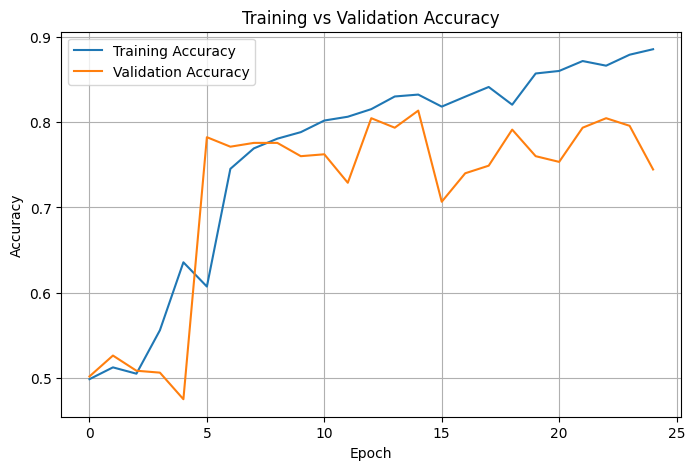

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(siamese_model.history.history['accuracy'], label='Training Accuracy')
plt.plot(siamese_model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

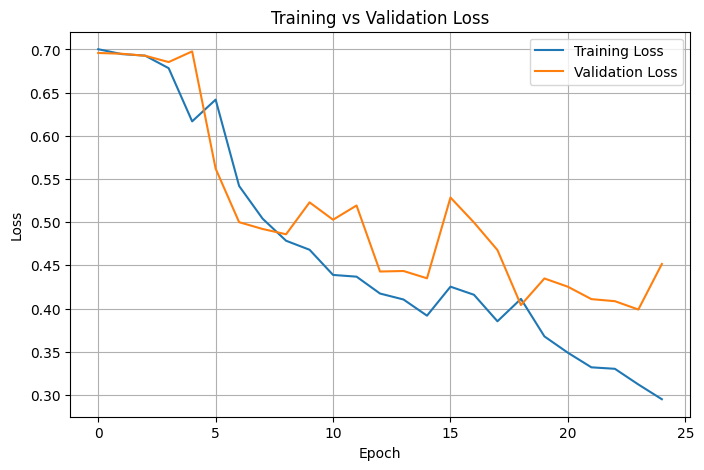

In [76]:
plt.figure(figsize=(8,5))
plt.plot(siamese_model.history.history['loss'], label='Training Loss')
plt.plot(siamese_model.history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [77]:
siamese_model.save("HW_4_siamese_model.h5")

# Test_Data Preparation

In [78]:
no_speakers_test = 20
utterances_speaker = 10
L = 5

In [79]:
X1_test_list,X2_test_list, y_test_list = [], [], []

for spk in range(no_speakers_test):
  start = spk * utterances_speaker
  end = start+utterances_speaker
  spk_utts = test_data[start:end]

  for l in range(L):
      i, j = np.random.choice(len(spk_utts), 2, replace=False)
      X1_test_list.append(spk_utts[i])
      X2_test_list.append(spk_utts[j])
      y_test_list.append(1.0)


  for k in range(L):
      neg_spk = np.random.choice([s for s in range(no_speakers_test) if s != spk])
      neg_start = neg_spk*utterances_speaker
      neg_end = neg_start+utterances_speaker
      neg_utt = test_data[np.random.randint(neg_start, neg_end)]
      pos_utt = spk_utts[np.random.randint(0, len(spk_utts))]
      X1_test_list.append(pos_utt)
      X2_test_list.append(neg_utt)
      y_test_list.append(0.0)



X1_test = np.array(X1_test_list, dtype=object)
X2_test = np.array(X2_test_list, dtype=object)
y_test = np.array(y_test_list)

In [80]:

max_T = max(max(s.shape[1] for s in X1_spec), max(s.shape[1] for s in X2_spec))


X1_spec_test = [to_spec(x) for x in X1_test]
X2_spec_test = [to_spec(x) for x in X2_test]

X1_pad_test = np.array([pad_spec(s) for s in X1_spec_test])
X2_pad_test = np.array([pad_spec(s) for s in X2_spec_test])


In [81]:
test_loss, test_acc = siamese_model.evaluate([X1_pad_test, X2_pad_test], y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 688ms/step - accuracy: 0.7800 - loss: 0.4452
Test Accuracy: 78.00%
